In [22]:
from brian2 import *
%matplotlib inline

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
WARNING    "vt" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value -50. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


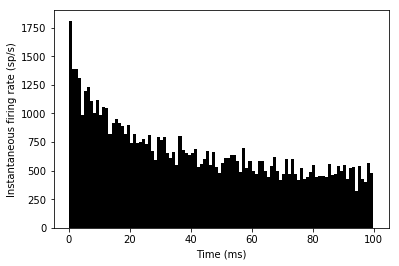

In [23]:
start_scope()

N = 1000
tau = 10*ms
vr = -70*mV
vt0 = -50*mV
delta_vt0 = 5*mV
tau_t = 100*ms
sigma = 0.5*(vt0-vr)
v_drive = 2*(vt0-vr)
duration = 100*ms

eqs = '''
dv/dt = (v_drive+vr-v)/tau + sigma*xi*tau**-0.5 : volt
dvt/dt = (vt0-vt)/tau_t : volt
'''

reset = '''
v = vr
vt += delta_vt0
'''

G = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms)
spikemon = SpikeMonitor(G)

G.v = 'rand()*(vt0-vr)+vr'
G.vt = vt0

run(duration)

_ = hist(spikemon.t/ms, 100, histtype='stepfilled', facecolor='k', weights=ones(len(spikemon))/(N*defaultclock.dt))
xlabel('Time (ms)')
ylabel('Instantaneous firing rate (sp/s)')

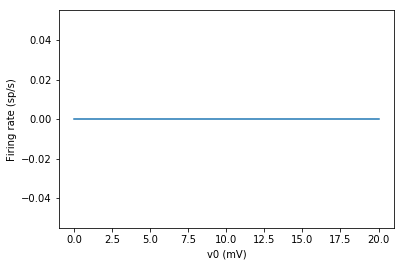

In [24]:
start_scope() 

n = 1000
duration = 1*second
tau = 10*ms
gL = 20*nS
cM = 0.2*nF
vL = -70*mV
eqs = '''
dv/dt = (v0 - v) / tau - gL * (v - vL) / cM : volt (unless refractory)
v0 : volt
'''
group = NeuronGroup(n, eqs, threshold='v > 10*mV', reset='v = 0*mV',
                    refractory=5*ms, method='linear')
group.v = 0*mV
group.v0 = '20*mV * i / (n-1)'

monitor = SpikeMonitor(group)

run(duration)
plot(group.v0/mV, monitor.count / duration)
xlabel('v0 (mV)')
ylabel('Firing rate (sp/s)')
show()

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.05s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]


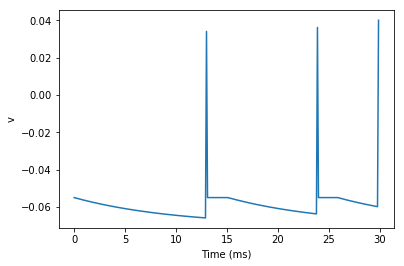

In [41]:
start_scope()

# Eventually do something like this
# def iaf_model(g_ampa, g_nmda, g_gaba)
c_m = 0.2 * nF
gl = 20 * nS
vl = -70 * mV
isyn = 0 * amp

vt = -50*mV
vr = -55*mV
ve = 0*mV
vi = -70*mV

ta = 2 * ms
tn = 100 * ms
tg = 5 * ms

gn = 1.5 * nS
gg = 2.5 * nS
ga = 3.5 * nS

alpha = 0.63

duration = 100 * ms
eqs = '''
dv/dt = (-gl * (v - vl) - isyn) / c_m : volt (unless refractory)
dsn/dt = -sn / tn : 1
dsa/dt = -sa / ta : 1
dsg/dt = -sg / tg : 1
ia = ga * sa * (v - ve) : amp
ig = gg * sg * (v - vi) : amp
nmda = (1 + e ** (-0.062*v / (1 * volt)) / 3.57) : 1
inm = gn * sn * (v - ve) / nmda : amp
isyn = ia + inm + ig : amp
'''

G = NeuronGroup(2, eqs, threshold='v>vt', reset='v=vr', refractory=2*ms)
G.v = 'vr'

S = Synapses(G, G,
             on_pre='''
             sa_post += 1
             sn_post += 0.63 * (1 - sn_post)
             sg_post += 1
             ''')
S.connect(i=0, j=1)
P = PoissonGroup(1, 100*Hz)

M = StateMonitor(G, 'v', record=True)

run(30*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');